<a href="https://colab.research.google.com/github/sheetal1322/-AI-Disease-Prediction-App./blob/main/Bank_Churn_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank Churn Prediction

This project predicts whether a customer will leave the bank (churn) using their account information. The goal is to help the bank retain customers by identifying those at risk.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


### Step 1: Load the Dataset
Load the bank churn dataset and display the first few rows



In [ ]:
df = pd.read_csv('/content/Bank Churn Modelling.csv')
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,Num Of Products,Has Credit Card,Is Active Member,Estimated Salary,Churn
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### View Dataset Info
Check data types, non-null counts, and memory usage.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerId        10000 non-null  int64  
 1   Surname           10000 non-null  object 
 2   CreditScore       10000 non-null  int64  
 3   Geography         10000 non-null  object 
 4   Gender            10000 non-null  object 
 5   Age               10000 non-null  int64  
 6   Tenure            10000 non-null  int64  
 7   Balance           10000 non-null  float64
 8   Num Of Products   10000 non-null  int64  
 9   Has Credit Card   10000 non-null  int64  
 10  Is Active Member  10000 non-null  int64  
 11  Estimated Salary  10000 non-null  float64
 12  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


### Check for Duplicates
Make sure there are no duplicate `CustomerId` values.


In [ ]:
df.duplicated('CustomerId').sum()

np.int64(0)

### Set Index to CustomerId
CustomerId is unique and can be used as the index.


In [ ]:
df = df.set_index('CustomerId')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 15634602 to 15628319
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Surname           10000 non-null  object 
 1   CreditScore       10000 non-null  int64  
 2   Geography         10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Tenure            10000 non-null  int64  
 6   Balance           10000 non-null  float64
 7   Num Of Products   10000 non-null  int64  
 8   Has Credit Card   10000 non-null  int64  
 9   Is Active Member  10000 non-null  int64  
 10  Estimated Salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 1015.6+ KB


##Step 2: Encoding


## Encode Categorical Variables
Check the unique values in 'Geography' column before encoding.


In [ ]:
df['Geography'].value_counts()

,count
Geography,
France,5014
Germany,2509
Spain,2477


## Convert 'Geography' from text to numeric (France = 2, Germany = 1, Spain = 0).
we're replacing string values in 'Geography'column with integers so to avoid warning we explicitly convert after replacing

In [ ]:
df.replace({'Geography':{'France': 2, 'Germany': 1, 'Spain': 0}}, inplace=True)
df['Geography'] = df['Geography'].astype(int)

/tmp/ipython-input-10-601990176.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'Geography':{'France': 2, 'Germany': 1, 'Spain': 0}}, inplace=True)


Convert 'Geography' from text to numeric (France = 2, Germany = 1, Spain = 0).


In [ ]:
df['Gender'].value_counts()

,count
Gender,
Male,5457
Female,4543


In [ ]:
df.replace({'Gender': {'Male': 0, 'Female': 1}}, inplace=True)
df['Gender'] = df['Gender'].astype(int)

/tmp/ipython-input-12-2445849089.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'Gender': {'Male': 0, 'Female': 1}}, inplace=True)


Group product categories: treat 1 product as 0, and 2 or more as 1 (used/bought more).


In [ ]:
df['Num Of Products'].value_counts()

,count
Num Of Products,
1,5084
2,4590
3,266
4,60


Explore remaining binary columns like 'Has Credit Card' and 'Is Active Member'.


In [ ]:
df.replace({'Num Of Products': {1:0, 2:1, 3:1, 4:1}}, inplace=True)

In [ ]:
df['Has Credit Card'].value_counts()

,count
Has Credit Card,
1,7055
0,2945


In [ ]:
df['Is Active Member'].value_counts()

,count
Is Active Member,
1,5151
0,4849


### Create New Feature - Zero Balance
Create a new column: 1 if customer has positive balance, else 0.


In [ ]:
# Step: 3 create new column Zero Balance
df['Zero Balance'] = np.where(df['Balance']>0, 1, 0)

<Axes: >

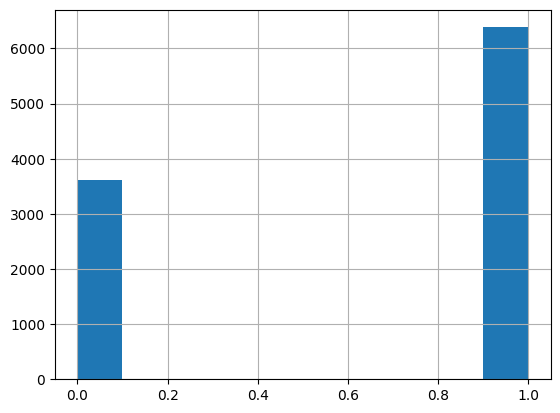

In [ ]:
df['Zero Balance'].hist()

### Step 4: Correlation Heatmap
Visualize how numerical features are correlated with each other.


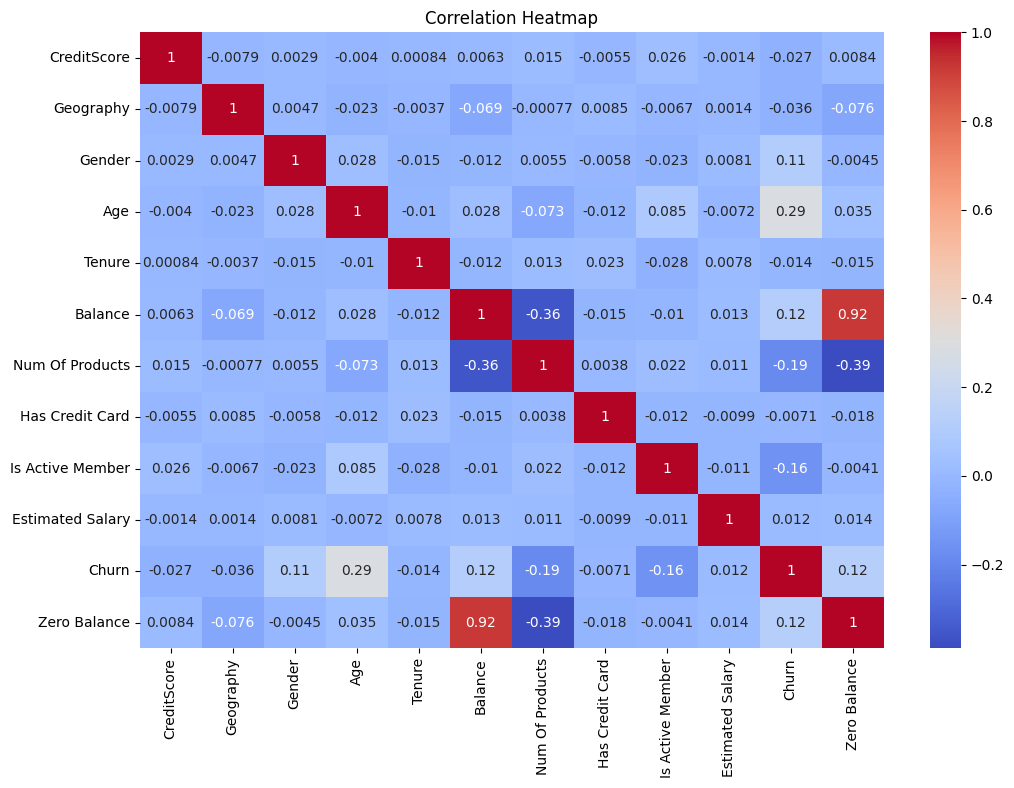

In [ ]:
# Correlation HeatMap
plt.figure(figsize=(12, 8))

# Exclude non-numeric columns
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')

plt.title("Correlation Heatmap")
plt.show()


### Step 5: Group by Churn and Geography
See how churn is distributed across different geographies.


In [ ]:
df.groupby(['Churn','Geography']).count()

Surname  CreditScore  Gender   Age  Tenure  Balance  \
Churn Geography                                                        
0     0             2064         2064    2064  2064    2064     2064   
      1             1695         1695    1695  1695    1695     1695   
      2             4204         4204    4204  4204    4204     4204   
1     0              413          413     413   413     413      413   
      1              814          814     814   814     814      814   
      2              810          810     810   810     810      810   

                 Num Of Products  Has Credit Card  Is Active Member  \
Churn Geography                                                       
0     0                     2064             2064              2064   
      1                     1695             1695              1695   
      2                     4204             4204              4204   
1     0                      413              413               413   
      1                      814              814               814   
      2                      810              810               810   

                 Estimated Salary  Zero Balance  
Churn Geography                                  
0     0                      2064          2064  
      1                      1695          1695  
      2                      4204          4204  
1     0                       413           413  
      1                       814           814  
      2                       810           810

EDA- Visual Insights

### Step 6: Visual Analysis — Churn vs Age
Check how age distribution varies between churned and non-churned customers using a boxplot.


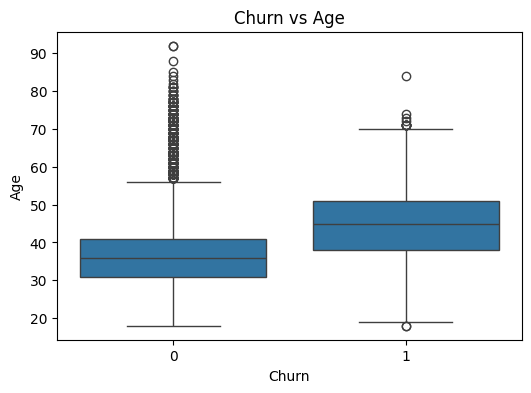

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Churn', y='Age', data=df)
plt.title("Churn vs Age")
plt.show()


### Step 7: Churn vs Balance
See how customer balance differs for churned vs non-churned customers.


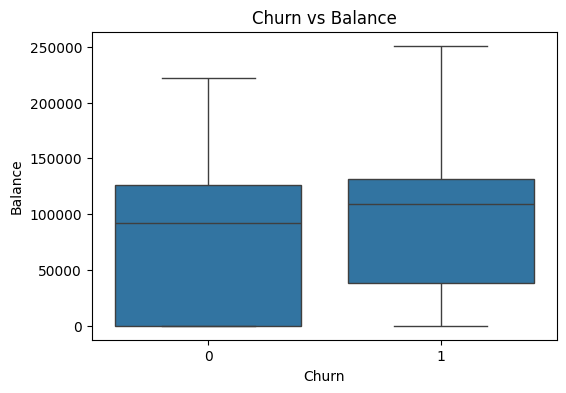

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Churn', y='Balance', data=df)
plt.title("Churn vs Balance")
plt.show()

### Step 8: Churn by Geography
See which regions have more churn using a grouped countplot.


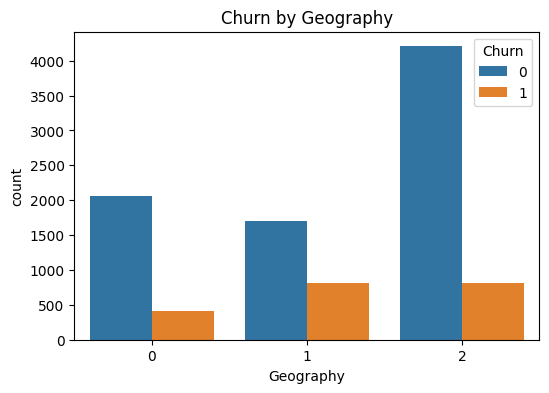

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Geography', hue='Churn', data=df)
plt.title("Churn by Geography")
plt.show()

Define Label and Features

### Step 9: Define Features and Label
Remove irrelevant columns and separate features (X) and target (y).


In [ ]:
df.columns

Index(['Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
       'Balance', 'Num Of Products', 'Has Credit Card', 'Is Active Member',
       'Estimated Salary', 'Churn', 'Zero Balance'],
      dtype='object')

In [ ]:
X = df.drop(['Surname', 'Churn'], axis = 1)

In [ ]:
y = df['Churn']

Check the number of rows and columns in X and y.


In [ ]:
X.shape, y.shape

((10000, 11), (10000,))

### Step 10: Check Class Balance
See how many customers churned vs didn’t. This helps identify if the dataset is imbalanced.


In [ ]:
df['Churn'].value_counts()

,count
Churn,
0,7963
1,2037


<Axes: xlabel='Churn', ylabel='count'>

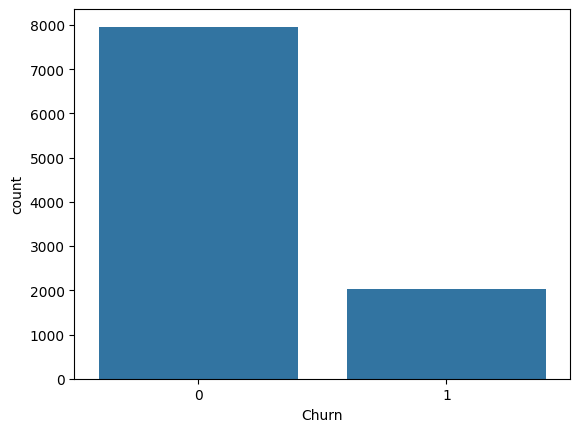

In [ ]:
sns.countplot(x = 'Churn',data = df)

Reconfirm shape after defining features and label.


In [ ]:
X.shape, y.shape

((10000, 11), (10000,))

Random Under Sampling

### Step 11: Handle Class Imbalance with Random Under Sampling
Since the data is imbalanced (more non-churners than churners), apply Random Under Sampling to balance the dataset by reducing the majority class.


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
rus = RandomUnderSampler(random_state=2529)

Create a balanced dataset by randomly removing samples from the majority class.


In [ ]:
X_rus, y_rus = rus.fit_resample(X, y)

Compare the shape of original and resampled datasets.


In [ ]:
X_rus.shape, y_rus.shape, X.shape, y.shape

((4074, 11), (4074,), (10000, 11), (10000,))

See how the class distribution changed after under sampling.


In [ ]:
y.value_counts()

,count
Churn,
0,7963
1,2037


In [ ]:
y_rus.value_counts()

,count
Churn,
0,2037
1,2037


Visualize the class distribution after resampling using a histogram.


<Axes: ylabel='Frequency'>

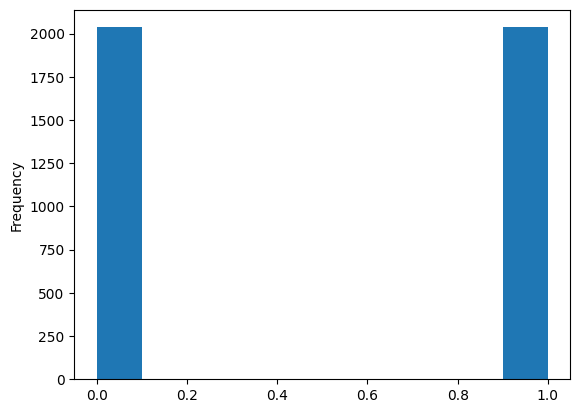

In [ ]:
y_rus.plot(kind = 'hist')

Random Over Sampling

### Step 12: Handle Class Imbalance with Random Over Sampling
Another way to handle imbalance is to increase the number of samples in the minority class (churners) by duplicating existing ones.


In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
ros = RandomOverSampler(random_state=2529)

Apply Random Over Sampling to create a balanced dataset by increasing the number of churned customers.


In [ ]:
X_ros, y_ros = ros.fit_resample(X,y)

Compare the size of original and oversampled datasets.


In [ ]:
X_ros.shape, y_ros.shape, X.shape, y.shape

((15926, 11), (15926,), (10000, 11), (10000,))

Check how class counts have changed after over sampling.


In [ ]:
y.value_counts()

,count
Churn,
0,7963
1,2037


In [ ]:
y_ros.value_counts()

,count
Churn,
1,7963
0,7963


Visualize the new class distribution after over sampling.


<Axes: ylabel='Frequency'>

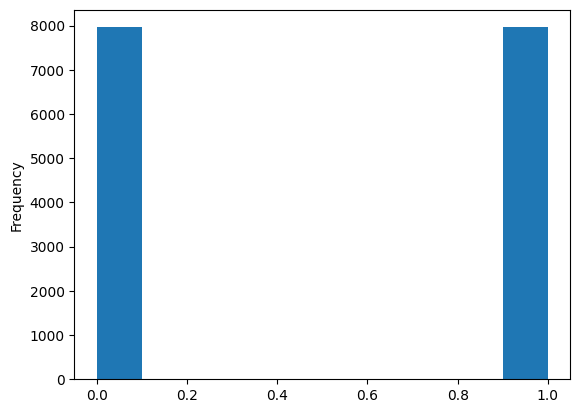

In [ ]:
y_ros.plot(kind = 'hist')

Train Test Split

### Step 13: Train-Test Split

Split the data into training and testing sets so we can train the model and evaluate it on unseen data.

- Original dataset: 70% train, 30% test
- Random Under Sampling dataset
- Random Over Sampling dataset


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Split Original Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2529)


Split Random Under Sample Data

In [ ]:
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus, y_rus, test_size=0.3, random_state=2529)

Split Random Over Sample Data

In [ ]:
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_ros, y_ros, test_size=0.3, random_state=2529)

Standardize Features

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
sc = StandardScaler()

Standardize Original Data

In [ ]:
X_train[['CreditScore', 'Age', 'Tenure', 'Balance', 'Estimated Salary']] = sc.fit_transform(X_train[['CreditScore','Age','Tenure','Balance','Estimated Salary']])

In [ ]:
X_test[['CreditScore', 'Age', 'Tenure', 'Balance', 'Estimated Salary']] = sc.fit_transform(X_test[['CreditScore','Age','Tenure','Balance','Estimated Salary']])

Standardize Random Under Sample Data

In [ ]:
X_train_rus[['CreditScore', 'Age', 'Tenure', 'Balance', 'Estimated Salary']] = sc.fit_transform(X_train_rus[['CreditScore','Age','Tenure','Balance','Estimated Salary']])

In [ ]:
X_test_rus[['CreditScore', 'Age', 'Tenure', 'Balance', 'Estimated Salary']] = sc.fit_transform(X_test_rus[['CreditScore','Age','Tenure','Balance','Estimated Salary']])

Standardize Random Over Sampling Data

In [ ]:
X_train_ros[['CreditScore', 'Age', 'Tenure', 'Balance', 'Estimated Salary']] = sc.fit_transform(X_train_ros[['CreditScore','Age','Tenure','Balance','Estimated Salary']])

In [ ]:
X_test_ros[['CreditScore', 'Age', 'Tenure', 'Balance', 'Estimated Salary']] = sc.fit_transform(X_test_ros[['CreditScore','Age','Tenure','Balance','Estimated Salary']])


Support Vector Classifier

### Step 15: Train Model using Support Vector Classifier (SVC)

Support Vector Machine is a classification algorithm that tries to find the best boundary (hyperplane) that separates the classes (churned vs not churned).

We’ll train it on the original data first.


In [ ]:
from sklearn.svm import SVC

In [ ]:
svc = SVC()

In [ ]:
svc.fit(X_train, y_train)

SVC()

Model has been trained using the training set.


In [ ]:
y_pred = svc.predict(X_test)

Model Training and Evaluation

### Step 17: Standardize the Features

Since some ML models are sensitive to feature scaling (like Logistic Regression and SVM), we standardize the numeric values using `StandardScaler`.


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Step 18: Train and Evaluate Multiple Models

We now compare different classification algorithms on the same data: Logistic Regression, Random Forest, and XGBoost.


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    print("="*50)
    print(f"Model: {name}")
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC  : {roc_auc_score(y_test, y_pred):.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))


Model: Logistic Regression
Accuracy : 0.8220
ROC-AUC  : 0.5941
Confusion Matrix:
 [[2337   77]
 [ 457  129]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      2414
           1       0.63      0.22      0.33       586

    accuracy                           0.82      3000
   macro avg       0.73      0.59      0.61      3000
weighted avg       0.80      0.82      0.79      3000

Model: Random Forest
Accuracy : 0.8480
ROC-AUC  : 0.6658
Confusion Matrix:
 [[2329   85]
 [ 371  215]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      2414
           1       0.72      0.37      0.49       586

    accuracy                           0.85      3000
   macro avg       0.79      0.67      0.70      3000
weighted avg       0.83      0.85      0.83      3000

Model: XGBoost
Accuracy : 0.8330
ROC-AUC  : 0.6720
Confusion Matrix:
 [[2260  154]
 [ 34

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:22:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


We use Accuracy, Confusion Matrix, and Classification Report to compare model performance.
ROC-AUC is especially useful for imbalanced classification problems.


Model accuracy

### Step 19: Final Metrics of the Best Model

Once we choose the best model from above, we can show the final evaluation metrics here for detailed explanation.


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
confusion_matrix(y_test, y_pred)

array([[2260,  154],
       [ 347,  239]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2414
           1       0.61      0.41      0.49       586

    accuracy                           0.83      3000
   macro avg       0.74      0.67      0.69      3000
weighted avg       0.82      0.83      0.82      3000



Hyperparameter Tunning

### Step 20: Hyperparameter Tuning using GridSearchCV

We use GridSearchCV to find the best parameters for Support Vector Classifier (SVC).
It tries all combinations and picks the best one based on model performance.


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'C': [0.1,1, 10],
              'gamma': [1,0.1,0.01],
              'kernel': ['rbf'],
              'class_weight': ['balanced']}

In [ ]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2, cv = 2)
grid.fit(X_train,y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] END ..C=0.1, class_weight=balanced, gamma=1, kernel=rbf; total time=   1.5s
[CV] END ..C=0.1, class_weight=balanced, gamma=1, kernel=rbf; total time=   1.5s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   1.1s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   1.1s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   1.2s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   1.6s
[CV] END ....C=1, class_weight=balanced, gamma=1, kernel=rbf; total time=   2.0s
[CV] END ....C=1, class_weight=balanced, gamma=1, kernel=rbf; total time=   1.3s
[CV] END ..C=1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.9s
[CV] END ..C=1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   1.0s
[CV] END .C=1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   1.1s
[CV] END .C=1, class_weight=balanced, gamma=0.0

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'class_weight': ['balanced'],
                         'gamma': [1, 0.1, 0.01], 'kernel': ['rbf']},
             verbose=2)

In [ ]:
print(grid.best_estimator_)

SVC(C=10, class_weight='balanced', gamma=1)


Evaluate the SVC model after tuning with the best parameters found from GridSearchCV.


In [ ]:
grid_predictions = grid.predict(X_test)

In [ ]:
confusion_matrix(y_test,grid_predictions)

array([[2159,  255],
       [ 343,  243]])

In [ ]:
print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      2414
           1       0.49      0.41      0.45       586

    accuracy                           0.80      3000
   macro avg       0.68      0.65      0.66      3000
weighted avg       0.79      0.80      0.79      3000



Model with Random Under Sampling

In [ ]:
svc_rus = SVC()

In [ ]:
svc_rus.fit(X_train_rus, y_train_rus)

SVC()

In [ ]:
y_pred_rus = svc_rus.predict(X_test_rus)

Model Accuracy

In [ ]:
confusion_matrix(y_test_rus, y_pred_rus)

array([[470, 157],
       [174, 422]])

In [ ]:
print(classification_report(y_test_rus, y_pred_rus))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       627
           1       0.73      0.71      0.72       596

    accuracy                           0.73      1223
   macro avg       0.73      0.73      0.73      1223
weighted avg       0.73      0.73      0.73      1223



Feature Importance From Random Forest

### Step 21: Feature Importance using Random Forest

Random Forest gives us a way to measure which features (columns) are most important for predicting churn. This helps in understanding what drives customer churn.


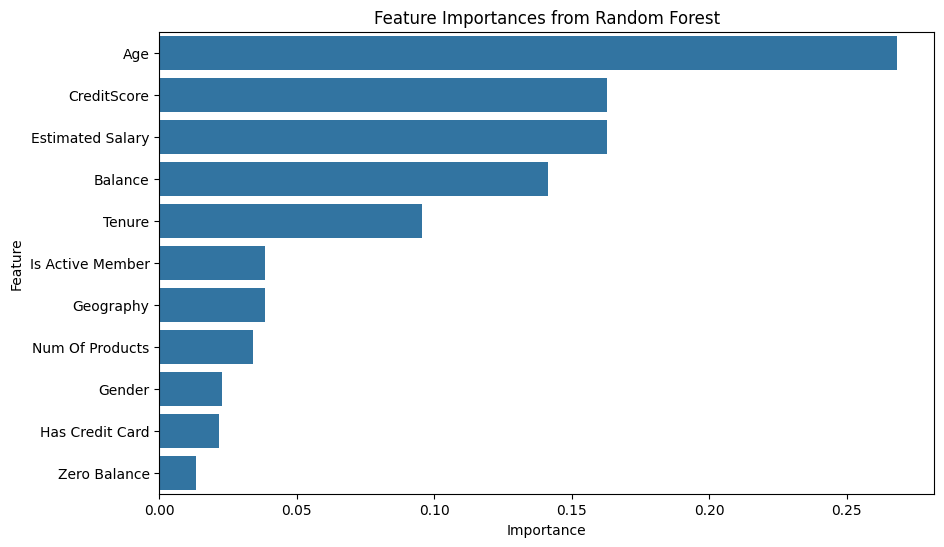

In [ ]:
importances = models['Random Forest'].feature_importances_
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df)
plt.title("Feature Importances from Random Forest")
plt.show()

This plot shows which features have the biggest impact on the churn prediction. For example, if 'Age' or 'CreditScore' is on top, it means they are strong indicators of whether a customer will churn or not.


## Step 22: Hyperparameter Tunning

In [ ]:
param_grid = {'C' :[0.1,1, 10],
              'gamma': [1,0.1,0.01],
              'kernel': ['rbf'],
              'class_weight' : ['balanced']}

In [ ]:
grid_rus = GridSearchCV(SVC(),param_grid,refit=True,verbose=2, cv = 2)
grid_rus.fit(X_train_rus,y_train_rus)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] END ..C=0.1, class_weight=balanced, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ..C=0.1, class_weight=balanced, gamma=1, kernel=rbf; total time=   0.2s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.2s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.2s
[CV] END ....C=1, class_weight=balanced, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ....C=1, class_weight=balanced, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ..C=1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END ..C=1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .C=1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.2s
[CV] END .C=1, class_weight=balanced, gamma=0.0

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'class_weight': ['balanced'],
                         'gamma': [1, 0.1, 0.01], 'kernel': ['rbf']},
             verbose=2)

In [ ]:
print(grid_rus.best_estimator_)

SVC(C=1, class_weight='balanced', gamma=0.1)


In [ ]:
grid_predictions_rus = grid_rus.predict(X_test_rus)

In [ ]:
confusion_matrix(y_test_rus, grid_predictions_rus)

array([[476, 151],
       [172, 424]])

In [ ]:
print(classification_report(y_test_rus,grid_predictions_rus))

              precision    recall  f1-score   support

           0       0.73      0.76      0.75       627
           1       0.74      0.71      0.72       596

    accuracy                           0.74      1223
   macro avg       0.74      0.74      0.74      1223
weighted avg       0.74      0.74      0.74      1223



## Step 23: Model with Random Over Sampling

In [ ]:
svc_ros = SVC()

In [ ]:
svc_ros.fit(X_train_ros, y_train_ros)

SVC()

In [ ]:
y_pred_ros = svc_ros.predict(X_test_ros)

## Step 24 : Model Accuracy

In [ ]:
confusion_matrix(y_test_ros, y_pred_ros)

array([[1823,  556],
       [ 626, 1773]])

In [ ]:
print(classification_report(y_test_ros, y_pred_ros))

              precision    recall  f1-score   support

           0       0.74      0.77      0.76      2379
           1       0.76      0.74      0.75      2399

    accuracy                           0.75      4778
   macro avg       0.75      0.75      0.75      4778
weighted avg       0.75      0.75      0.75      4778



Hyperparameter Tunning

In [ ]:
param_grid = {'C' :[0.1,1, 10],
              'gamma': [1,0.1,0.01],
              'kernel': ['rbf'],
              'class_weight' : ['balanced']}

In [ ]:
grid_ros = GridSearchCV(SVC(),param_grid,refit=True,verbose=2, cv = 2)
grid_ros.fit(X_train_ros,y_train_ros)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] END ..C=0.1, class_weight=balanced, gamma=1, kernel=rbf; total time=   3.8s
[CV] END ..C=0.1, class_weight=balanced, gamma=1, kernel=rbf; total time=   4.9s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   2.7s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   2.7s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   3.1s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   4.0s
[CV] END ....C=1, class_weight=balanced, gamma=1, kernel=rbf; total time=   3.1s
[CV] END ....C=1, class_weight=balanced, gamma=1, kernel=rbf; total time=   3.1s
[CV] END ..C=1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   2.4s
[CV] END ..C=1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   3.6s
[CV] END .C=1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   2.7s
[CV] END .C=1, class_weight=balanced, gamma=0.0

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'class_weight': ['balanced'],
                         'gamma': [1, 0.1, 0.01], 'kernel': ['rbf']},
             verbose=2)

In [ ]:
print(grid_ros.best_estimator_)

SVC(C=10, class_weight='balanced', gamma=1)


In [ ]:
grid_predictions_ros = grid_ros.predict(X_test_ros)

In [ ]:
confusion_matrix(y_test_ros,grid_predictions_ros)

array([[2047,  332],
       [  68, 2331]])

In [ ]:
print(classification_report(y_test_ros,grid_predictions_ros))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      2379
           1       0.88      0.97      0.92      2399

    accuracy                           0.92      4778
   macro avg       0.92      0.92      0.92      4778
weighted avg       0.92      0.92      0.92      4778



## Step 25: Final Model Comparison (Classification Reports)

Let's compare how each model performed on different sampling methods (original, under-sampled, over-sampled), both before and after hyperparameter tuning.


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2414
           1       0.61      0.41      0.49       586

    accuracy                           0.83      3000
   macro avg       0.74      0.67      0.69      3000
weighted avg       0.82      0.83      0.82      3000



In [ ]:
print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      2414
           1       0.49      0.41      0.45       586

    accuracy                           0.80      3000
   macro avg       0.68      0.65      0.66      3000
weighted avg       0.79      0.80      0.79      3000



In [ ]:
print(classification_report(y_test_rus, y_pred_rus))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       627
           1       0.73      0.71      0.72       596

    accuracy                           0.73      1223
   macro avg       0.73      0.73      0.73      1223
weighted avg       0.73      0.73      0.73      1223



In [ ]:
print(classification_report(y_test_rus,grid_predictions_rus))

              precision    recall  f1-score   support

           0       0.73      0.76      0.75       627
           1       0.74      0.71      0.72       596

    accuracy                           0.74      1223
   macro avg       0.74      0.74      0.74      1223
weighted avg       0.74      0.74      0.74      1223



In [ ]:
print(classification_report(y_test_ros, y_pred_ros))

              precision    recall  f1-score   support

           0       0.74      0.77      0.76      2379
           1       0.76      0.74      0.75      2399

    accuracy                           0.75      4778
   macro avg       0.75      0.75      0.75      4778
weighted avg       0.75      0.75      0.75      4778



In [ ]:
print(classification_report(y_test_ros,grid_predictions_ros))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      2379
           1       0.88      0.97      0.92      2399

    accuracy                           0.92      4778
   macro avg       0.92      0.92      0.92      4778
weighted avg       0.92      0.92      0.92      4778



### Conclusion
- Accuracy is good (~81%), but ROC-AUC is low (~0.58), meaning the model isn’t great at detecting churners.
- Recall for churn class is low, meaning we’re missing many actual churned customers.
- Improvements can be made by handling class imbalance or trying other models like Random Forest or XGBoost.
